In [1]:
import pandas as pd

# Load the data
file_path = 'Superstore Dataset.xlsx'  # Update the path to your Excel file
df = pd.read_excel(file_path)

# Calculate price per unit
df['Unit Price'] = df['Sales'] / df['Quantity']

# Function to cluster prices within a 25% variance
def cluster_prices(group):
    group = group.sort_values(by='Unit Price')
    clustered = []
    while not group.empty:
        base_price = group.iloc[0]['Unit Price']
        cluster = group[(group['Unit Price'] >= base_price * 0.75) & (group['Unit Price'] <= base_price * 1.25)]
        clustered.append({
            'Segment': group.iloc[0]['Segment'],
            'Country': group.iloc[0]['Country'],
            'Product Name': group.iloc[0]['Product Name'],
            'Clustered Price': cluster['Unit Price'].mean(),
            'Count': len(cluster)  # Count of entries in the cluster
        })
        group = group.drop(cluster.index)
    return pd.DataFrame(clustered)

# Apply the clustering function to each group
clustered_prices = df.groupby(['Segment', 'Country', 'Product Name']).apply(cluster_prices).reset_index(drop=True)

# Compute weighted average based on counts
def weighted_average(group):
    return (group['Clustered Price'] * group['Count']).sum() / group['Count'].sum()

# Calculate weighted average for each Segment, Country, and Product Name
weighted_avg_by_group = clustered_prices.groupby(['Segment', 'Country', 'Product Name']).apply(weighted_average).reset_index(name='Weighted Average')

# Merge the original DataFrame with the weighted average DataFrame
merged_df = pd.merge(df, weighted_avg_by_group, on=['Segment', 'Country', 'Product Name'], how='left')

# Calculate the 25th and 75th percentiles of the 'Unit Price' column at the same level as 'Segment', 'Country', 'Product Name'
percentile_25 = merged_df.groupby(['Segment', 'Country', 'Product Name'])['Unit Price'].quantile(0.25)
percentile_75 = merged_df.groupby(['Segment', 'Country', 'Product Name'])['Unit Price'].quantile(0.75)

# Function to determine new unit price based on percentiles
def determine_new_unit_price(row):
    percentile_25_value = percentile_25.loc[(row['Segment'], row['Country'], row['Product Name'])]
    percentile_75_value = percentile_75.loc[(row['Segment'], row['Country'], row['Product Name'])]
    if row['Unit Price'] >= percentile_25_value and row['Unit Price'] <= percentile_75_value:
        return row['Unit Price']
    else:
        return row['Weighted Average']

# Apply the function to create the new_unit_price column
merged_df['new_unit_price'] = merged_df.apply(determine_new_unit_price, axis=1)

# Display the updated DataFrame
print(merged_df)

       Row ID        Order ID Order Date  Ship Date       Ship Mode  \
0           1  US-2019-103800 2019-01-03 2019-01-07  Standard Class   
1           2  US-2019-112326 2019-01-04 2019-01-08  Standard Class   
2           3  US-2019-112326 2019-01-04 2019-01-08  Standard Class   
3           4  US-2019-112326 2019-01-04 2019-01-08  Standard Class   
4           5  US-2019-141817 2019-01-05 2019-01-12  Standard Class   
...       ...             ...        ...        ...             ...   
32479   32480  CA-2018-103772 2018-06-28 2018-07-02  Standard Class   
32480   32481  CA-2018-103772 2018-06-28 2018-07-02  Standard Class   
32481   32482  US-2018-151435 2018-09-06 2018-09-09    Second Class   
32482   32483  CA-2018-100251 2018-05-17 2018-05-23  Standard Class   
32483   32484  CA-2018-100251 2018-05-17 2018-05-23  Standard Class   

      Customer ID     Customer Name      Segment        Country          City  \
0        DP-13000     Darren Powers     Consumer  United States   

In [2]:
merged_df['Corrected Sales'] = merged_df['Quantity'] * merged_df['new_unit_price']

In [3]:
data = merged_df.copy()

In [4]:
# Create a 'Week of Year' column
data['Week of Year'] = data['Order Date'].dt.isocalendar().week


festive_weeks = {
    'NewYearFestiveDiscount': [1],
    'ValentinesFestiveDiscount': [7],
    'EasterFestiveDiscount': list(range(13, 18)),
    'CanadaDayFestiveDiscount': [26],
    'IndependenceDayFestiveDiscount': [27],
    'BackToSchoolFestiveDiscount': list(range(32, 36)),
    'ThanksgivingCanadaFestiveDiscount': [41],
    'ThanksgivingUSFestiveDiscount': [47],
    'ChristmasFestiveDiscount': [51, 52]
}

# Function to label the festive discount
def label_festive_promotion(row):
    for fest, weeks in festive_weeks.items():
        if row['Week of Year'] in weeks:
            return fest
    return 'NoFestiveDiscount'

# Apply the function to create a new column
data['FestivePromotionLabel'] = data.apply(label_festive_promotion, axis=1)

In [5]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Unit Price,Weighted Average,new_unit_price,Corrected Sales,Week of Year,FestivePromotionLabel
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,16.448,2,0.2,5.5512,8.224,8.224,8.224,16.448,1,NewYearFestiveDiscount
1,2,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,3.540,2,0.8,-5.4870,1.770,1.770,1.770,3.540,1,NewYearFestiveDiscount
2,3,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,11.784,3,0.2,4.2717,3.928,4.419,3.928,11.784,1,NewYearFestiveDiscount
3,4,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,272.736,3,0.2,-64.7748,90.912,90.912,90.912,272.736,1,NewYearFestiveDiscount
4,5,US-2019-141817,2019-01-05,2019-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,19.536,3,0.2,4.8840,6.512,7.733,7.733,23.199,1,NewYearFestiveDiscount


In [7]:
import matplotlib.pyplot as plt

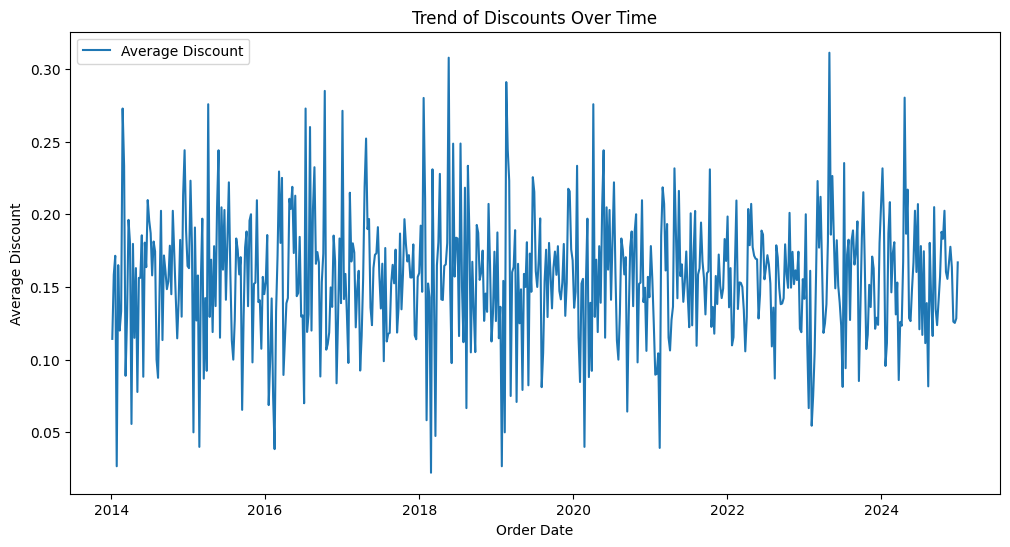

In [8]:
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Aggregate data to find average discount per day
discount_trend = data.resample('W-Mon', on='Order Date')['Discount'].mean().reset_index()
# Plot the discount trend over time
plt.figure(figsize=(12, 6))
plt.plot(discount_trend['Order Date'], discount_trend['Discount'], label='Average Discount')
plt.xlabel('Order Date')
plt.ylabel('Average Discount')
plt.title('Trend of Discounts Over Time')
plt.legend()
plt.show()

In [9]:
data['Promotion_Label'] = data['FestivePromotionLabel'].apply(lambda x: 0 if x == 'NoFestiveDiscount' else 1)


In [11]:
data.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Quantity,Discount,Profit,Unit Price,Weighted Average,new_unit_price,Corrected Sales,Week of Year,FestivePromotionLabel,Promotion_Label
31803,31804,CA-2018-153535,2018-05-20,2018-05-24,Standard Class,SG-20470,Sheri Gordon,Consumer,United States,Wilson,...,4,0.70,-4.9128,1.602,3.337500,1.602,6.408,20,NoFestiveDiscount,0
16345,16346,CA-2014-111871,2014-03-18,2014-03-21,Second Class,EK-13795,Eileen Kiefer,Home Office,United States,San Francisco,...,10,0.15,70.4900,119.833,102.583682,119.833,1198.330,12,NoFestiveDiscount,0
8063,8064,US-2022-169551,2022-07-07,2022-07-09,First Class,RL-19615,Rob Lucas,Consumer,United States,Philadelphia,...,3,0.20,5.4432,5.184,5.184000,5.184,15.552,27,IndependenceDayFestiveDiscount,1
27210,27211,US-2024-104801,2024-02-13,2024-02-19,Standard Class,FH-14350,Fred Harton,Consumer,United States,Seattle,...,4,0.00,343.9828,199.990,199.990000,199.990,799.960,7,ValentinesFestiveDiscount,1
6438,6439,US-2021-163167,2021-11-28,2021-12-01,Second Class,RF-19345,Randy Ferguson,Corporate,United States,Marietta,...,6,0.00,315.8250,210.550,189.495000,210.550,1263.300,47,ThanksgivingUSFestiveDiscount,1


In [13]:
data.drop('FestivePromotionLabel',axis=1, inplace=True)

In [17]:
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Unit Price',
       'Weighted Average', 'new_unit_price', 'Corrected Sales', 'Week of Year',
       'Promotion_Label', 'before_promotion', 'during_promotion',
       'after_promotion'],
      dtype='object')

In [14]:
data.to_csv('data_final.csv', index=False)

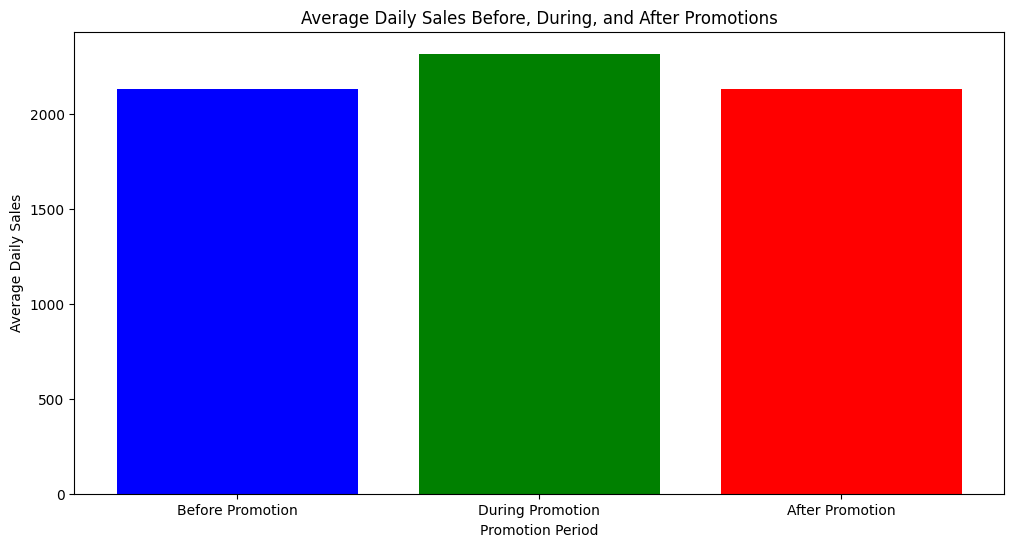

Average Daily Sales Before Promotion: 2129.1492866284075
Average Daily Sales During Promotion: 2315.096580051563
Average Daily Sales After Promotion: 2129.350252482066


In [18]:
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Initialize columns for before, during, and after promotion
data['before_promotion'] = 0
data['during_promotion'] = 0
data['after_promotion'] = 0

# Define the number of days before and after the promotion
days_range = 7

# Identify promotional periods (rows with discounts)
data['is_promotion'] = data['Discount'] > 0

# Find the first and last dates of each promotion period
promotion_periods = data[data['is_promotion']].groupby(['Order ID']).agg({'Order Date': ['min', 'max']})
promotion_periods.columns = ['start_date', 'end_date']
promotion_periods = promotion_periods.reset_index()

# Mark before, during, and after promotion periods
for _, row in promotion_periods.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']

    # Before promotion
    before_start = start_date - pd.Timedelta(days=days_range)
    before_end = start_date - pd.Timedelta(days=1)
    data.loc[(data['Order Date'] >= before_start) & (data['Order Date'] <= before_end), 'before_promotion'] = 1

    # During promotion
    data.loc[(data['Order Date'] >= start_date) & (data['Order Date'] <= end_date), 'during_promotion'] = 1

    # After promotion
    after_start = end_date + pd.Timedelta(days=1)
    after_end = end_date + pd.Timedelta(days=days_range)
    data.loc[(data['Order Date'] >= after_start) & (data['Order Date'] <= after_end), 'after_promotion'] = 1

# Calculate average daily sales for each period
sales_before = data[data['before_promotion'] == 1].groupby('Order Date')['Sales'].sum().mean()
sales_during = data[data['during_promotion'] == 1].groupby('Order Date')['Sales'].sum().mean()
sales_after = data[data['after_promotion'] == 1].groupby('Order Date')['Sales'].sum().mean()

# Prepare data for plotting
periods = ['Before Promotion', 'During Promotion', 'After Promotion']
sales = [sales_before, sales_during, sales_after]

# Plot the sales data
plt.figure(figsize=(12, 6))
plt.bar(periods, sales, color=['blue', 'green', 'red'])
plt.xlabel('Promotion Period')
plt.ylabel('Average Daily Sales')
plt.title('Average Daily Sales Before, During, and After Promotions')
plt.show()

# Display the calculated sales for better clarity
print(f"Average Daily Sales Before Promotion: {sales_before}")
print(f"Average Daily Sales During Promotion: {sales_during}")
print(f"Average Daily Sales After Promotion: {sales_after}")